# Step-by-step demonstration

## Lib Imports and configurations

In [1]:
# %matplotlib notebook
# %matplotlib inline 
%load_ext autoreload
%autoreload 2

import sys
import os
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ruptures as rpt

sys.path.append("Codes/")

import TMPD_utils
import TMPD_class

import warnings
warnings.filterwarnings("ignore")

import gc
gc.enable()

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 150)
# pd.set_option('display.float_format', lambda x: f'{x:,.3f}')
pd.options.display.float_format = '{:.4f}'.format


## Loading event log

In [2]:
# Mapping all event_logs paths
logs_path = glob.glob("Input/Synthetic/CPN_Logs_Characterization_Ext_ (Ostovar - Robust)/FragmentChange/*/*/*/*/*.mxml*")

# Removing the logs with 2500 events (based on Maaradji paper)
logs_path = [x for x in logs_path if "2.5" not in x]

# Showing mapped paths
print("How many logs? ", len(logs_path))
pd.DataFrame(logs_path)

How many logs?  375


,0
0,Input/Synthetic/CPN_Logs_Characterization_Ext_ (Ostovar - Robust)/FragmentChange\Size1\Atomic\ConditionalMove\output\ConditionalMove.mxml.gz
1,Input/Synthetic/CPN_Logs_Characterization_Ext_ (Ostovar - Robust)/FragmentChange\Size1\Atomic\ConditionalMove\output\ConditionalMove_2.mxml.gz
2,Input/Synthetic/CPN_Logs_Characterization_Ext_ (Ostovar - Robust)/FragmentChange\Size1\Atomic\ConditionalMove\output\ConditionalMove_5.mxml.gz
3,Input/Synthetic/CPN_Logs_Characterization_Ext_ (Ostovar - Robust)/FragmentChange\Size1\Atomic\ConditionalRemoval\output\ConditionalRemoval.mxml.gz
4,Input/Synthetic/CPN_Logs_Characterization_Ext_ (Ostovar - Robust)/FragmentChange\Size1\Atomic\ConditionalRemoval\output\ConditionalRemoval_2.mxml.gz
...,...
370,Input/Synthetic/CPN_Logs_Characterization_Ext_ (Ostovar - Robust)/FragmentChange\Size5\Nested\RIO\output\RIO_2.mxml.gz
371,Input/Synthetic/CPN_Logs_Characterization_Ext_ (Ostovar - Robust)/FragmentChange\Size5\Nested\RIO\output\RIO_5.mxml.gz
372,Input/Synthetic/CPN_Logs_Characterization_Ext_ (Ostovar - Robust)/FragmentChange\Size5\Nested\ROI\output\ROI.mxml.gz
373,Input/Synthetic/CPN_Logs_Characterization_Ext_ (Ostovar - Robust)/FragmentChange\Size5\Nested\ROI\output\ROI_2.mxml.gz


<!-- ![Alt text](../Images/Concept_drift_firstcycle_steps_eng.png "General steps") -->

In [3]:
# Loading first event log
log_path = logs_path[0]
event_log = TMPD_utils.parse_mxml(log_path, gzip=True)

# This is a specifc step for this event log that separates in different rows the start and end of an activity. As we will only use one timestamp, we are filtering only the row representing the end of an activity.  
# event_log = event_log[event_log.EventType == "complete"]

# Save original event index
event_log = event_log.reset_index(names='original_index') 

# Create an id based on the order of the event in the raw event log
event_log["Event_order_id"] = event_log.index

# This is a specifc step for this event log, because it have duplicated case ids. So we create a new case id.
event_log["Trace_order"] = TMPD_utils.cumulative_counting(event_log["TraceId"])

# Showing loaded event log
event_log.head(15)

,original_index,TraceId,Data,WorkflowModelElement,EventType,timestamp,Activity,Event_order_id,Trace_order
0,0,1,1970-01-01T10:33:47.462+10:00,a,complete,1970-01-01T10:33:47.462+10:00,a,0,0
1,1,1,1970-01-01T11:28:08.980+10:00,e,complete,1970-01-01T11:28:08.980+10:00,e,1,0
2,2,1,1970-01-01T11:32:51.926+10:00,d,complete,1970-01-01T11:32:51.926+10:00,d,2,0
3,3,1,1970-01-01T11:39:34.303+10:00,c,complete,1970-01-01T11:39:34.303+10:00,c,3,0
4,4,1,1970-01-01T12:32:42.811+10:00,i,complete,1970-01-01T12:32:42.811+10:00,i,4,0
5,5,1,1970-01-01T13:29:14.845+10:00,j,complete,1970-01-01T13:29:14.845+10:00,j,5,0
6,6,1,64,k,complete,1970-01-01T14:25:40.585+10:00,k,6,0
7,7,1,1970-01-01T15:26:04.500+10:00,j,complete,1970-01-01T15:26:04.500+10:00,j,7,0
8,8,1,38,k,complete,1970-01-01T16:12:34.754+10:00,k,8,0
9,9,1,1970-01-01T16:54:45.674+10:00,m,complete,1970-01-01T16:54:45.674+10:00,m,9,0


## Step 1 - Instantiating class and setting event log

In [4]:
# Iniatializing the TMPD_class
TMPD_instance = TMPD_class.TMPD(scenario='offline')

# Setting the transition log
TMPD_instance.set_transition_log(event_log, case_id='Trace_order', activity_key='Activity', timestamp_key='timestamp', other_columns_keys=[])

# Executing the transition log
TMPD_instance.run_transition_log()

# Showing the transition log created
TMPD_instance.get_transition_log().head(15)

,original_index,case_id,activity_from,timestamp_from,activity_to,timestamp_to,transition_id,case_order
0,0,0,a,1970-01-01T10:33:47.462+10:00,e,1970-01-01T11:28:08.980+10:00,0,0
1,1,0,e,1970-01-01T11:28:08.980+10:00,d,1970-01-01T11:32:51.926+10:00,1,1
2,2,0,d,1970-01-01T11:32:51.926+10:00,c,1970-01-01T11:39:34.303+10:00,2,2
3,3,0,c,1970-01-01T11:39:34.303+10:00,i,1970-01-01T12:32:42.811+10:00,3,3
4,4,0,i,1970-01-01T12:32:42.811+10:00,j,1970-01-01T13:29:14.845+10:00,4,4
5,5,0,j,1970-01-01T13:29:14.845+10:00,k,1970-01-01T14:25:40.585+10:00,5,5
6,6,0,k,1970-01-01T14:25:40.585+10:00,j,1970-01-01T15:26:04.500+10:00,6,6
7,7,0,j,1970-01-01T15:26:04.500+10:00,k,1970-01-01T16:12:34.754+10:00,7,7
8,8,0,k,1970-01-01T16:12:34.754+10:00,m,1970-01-01T16:54:45.674+10:00,8,8
9,9,0,m,1970-01-01T16:54:45.674+10:00,l,1970-01-01T17:10:50.445+10:00,9,9


## Step 2 - Setting Window Strategy

In [5]:
# Setting the window strategy parameters
TMPD_instance.set_windowing_strategy(window_size_mode = 'Fixed', window_size = 4000, window_ref_mode = 'Fixed', overlap = True, sliding_step = 200, continuous = True)

# Executing the window strategy indexation
TMPD_instance.run_windowing_strategy()

# Showing the windows indexes
dict(list(TMPD_instance.get_windowing_strategy().items())[:15])

{0: {'start': 0, 'end': 4000, 'window_index': 0},
 1: {'start': 200, 'end': 4200, 'window_index': 1},
 2: {'start': 400, 'end': 4400, 'window_index': 2},
 3: {'start': 600, 'end': 4600, 'window_index': 3},
 4: {'start': 800, 'end': 4800, 'window_index': 4},
 5: {'start': 1000, 'end': 5000, 'window_index': 5},
 6: {'start': 1200, 'end': 5200, 'window_index': 6},
 7: {'start': 1400, 'end': 5400, 'window_index': 7},
 8: {'start': 1600, 'end': 5600, 'window_index': 8},
 9: {'start': 1800, 'end': 5800, 'window_index': 9},
 10: {'start': 2000, 'end': 6000, 'window_index': 10},
 11: {'start': 2200, 'end': 6200, 'window_index': 11},
 12: {'start': 2400, 'end': 6400, 'window_index': 12},
 13: {'start': 2600, 'end': 6600, 'window_index': 13},
 14: {'start': 2800, 'end': 6800, 'window_index': 14}}

## Step 3 - Setting Process Representation (using Transition Matrix)

In [6]:
# Setting the Transition Matrix (TM) process representation
TMPD_instance.set_process_representation(threshold_anomaly=0
                                    , control_flow_features=['frequency', 'probability', 'causality', 'parallel', 'choice']
                                    , time_features={'average_time':'timestamp', 'time_std':'timestamp'}
                                    , resource_features={}
                                    , data_features={})

# Executing the process_representation using all dataset just for an example
TMPD_instance.run_process_representation(TMPD_instance.transition_log)

# Showing the process representation created
TMPD_instance.get_process_representation().head(15)

frequency  probability  causality  parallel  \
activity_from activity_to                                                
DRIFT_PO      DRIFT_PO             0       0.0000          0         0   
              c                    0       0.0000          0         0   
              d                    0       0.0000          0         0   
              e                    0       0.0000          0         0   
              f                    0       0.0000          0         0   
              g                    0       0.0000          0         0   
              h                    0       0.0000          0         0   
              i                    0       0.0000          0         0   
              j                    0       0.0000          0         0   
              k                    0       0.0000          0         0   
              l                    0       0.0000          0         0   
              m                    0       0.0000          0         0   
              n                 1997       0.6659          1         0   
              o                 1002       0.3341          1         0   
              p                    0       0.0000          0         0   

                           choice  average_time  time_std  
activity_from activity_to                                  
DRIFT_PO      DRIFT_PO          1        0.0000    0.0000  
              c                 1        0.0000    0.0000  
              d                 1        0.0000    0.0000  
              e                 1        0.0000    0.0000  
              f                 1        0.0000    0.0000  
              g                 1        0.0000    0.0000  
              h                 1        0.0000    0.0000  
              i                 1        0.0000    0.0000  
              j                 1        0.0000    0.0000  
              k                 1        0.0000    0.0000  
              l                 1        0.0000    0.0000  
              m                 1        0.0000    0.0000  
              n                 0       59.6995   10.1916  
              o                 0       60.0578   10.4068  
              p                 1        0.0000    0.0000

## Step 4 - Setting Change Representation

In [8]:
# Defining the change features
change_features_strategy_dict = {
    'delta_matrix_strategy': 
        {
            'frequency_delta' : {'process_feature':'frequency', 'method':'aggregation', 'agg_function' : 'sum'}
            , 'probability_delta' : {'process_feature':'probability', 'method':'aggregation', 'agg_function' : 'sum'}
            , 'frequency_delta_percentage' : {'process_feature':'frequency', 'method':'percentage'}
            , 'prob_freq_delta_weight' : {'process_feature':'probability', 'method':'aggregation_weight', 'agg_function' : 'sum', 'weight_feature' : 'frequency'}
        }
    , 'statistic_test_strategy' : 
        {
            'frequency_gtest_pvalue' : {'process_feature':'frequency', 'method':'g_test', 'contingency_matrix_sum_value' : '5', 'remove_zeros':'True'}
            , 'frequency_cramersv' : {'process_feature':'frequency', 'method':'cramers_v', 'contingency_matrix_sum_value' : '5', 'remove_zeros':'True'}
        }
    }

# Setting Change Representation
TMPD_instance.set_change_representation(change_features_strategy_dict)

# Executing the Change Representation using the window strategy
TMPD_instance.run_change_representation()

# Showing the Change Representation created
TMPD_instance.get_change_representation().head(15)

,start,end,window_index,reference_window_index,frequency_delta,probability_delta,frequency_delta_percentage,prob_freq_delta_weight,frequency_gtest_pvalue,frequency_cramersv
0,0,4000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,200,4200,1,0,68.0000,0.4125,0.0085,0.7221,1.0000,0.0000
2,400,4400,2,0,114.0000,0.6894,0.0143,2.0328,1.0000,0.0000
3,600,4600,3,0,148.0000,0.6956,0.0185,2.4374,1.0000,0.0000
4,800,4800,4,0,170.0000,0.7605,0.0213,3.3470,1.0000,0.0000
5,1000,5000,5,0,200.0000,0.8048,0.0250,3.4705,1.0000,0.0000
6,1200,5200,6,0,166.0000,0.8455,0.0208,3.2042,1.0000,0.0000
7,1400,5400,7,0,204.0000,0.9840,0.0255,4.4173,1.0000,0.0000
8,1600,5600,8,0,208.0000,1.0660,0.0260,5.1030,1.0000,0.0000
9,1800,5800,9,0,192.0000,0.9692,0.0240,4.6903,1.0000,0.0000


## Step 5 - Setting Detection Task

In [10]:
# Defining detection strategies
detection_task_strategy_dict = {
    'time_series_strategy': 
    {
        'cpd_frequency_delta' : {'change_features':['frequency_delta'], 'method':'cpd_pelt', 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1', 'smooth' : '3'}
        , 'cpd_prob_freq_delta' : {'change_features':['prob_freq_delta_weight'], 'method':'cpd_pelt', 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1', 'smooth' : '3'}
    }
    , 'threshold_strategy' : 
    {
        'gtest_frequency' : {'change_features':['frequency_gtest_pvalue'], 'method':'comparison_operator', 'operator' : 'le', 'threshold_value' : '0.025', 'smooth' : '3'}
        , 'fixed_frequency_delta_percentage' : {'change_features':['frequency_delta_percentage'], 'method':'comparison_operator', 'operator' : 'ge', 'threshold_value' : '0.05', 'smooth' : '3'}
    }
}

# Setting Detection Task
TMPD_instance.set_detection_task(detection_task_strategy_dict)

# Executing the Detection Task
TMPD_instance.run_detection_task()

# Showing Detection Task Results
TMPD_instance.get_detection_task()


,detection_strategy,detection_feature,detection_results
0,time_series_strategy,cpd_frequency_delta,"[61, 95, 104, 204, 217, 316]"
1,time_series_strategy,cpd_prob_freq_delta,"[96, 108, 200, 212, 316]"
2,threshold_strategy,gtest_frequency,"[91, 217, 316]"
3,threshold_strategy,fixed_frequency_delta_percentage,"[90, 224, 249, 262, 301, 316]"


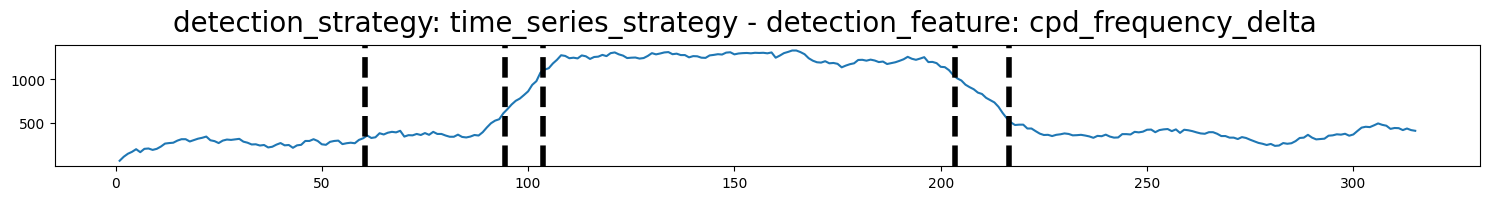

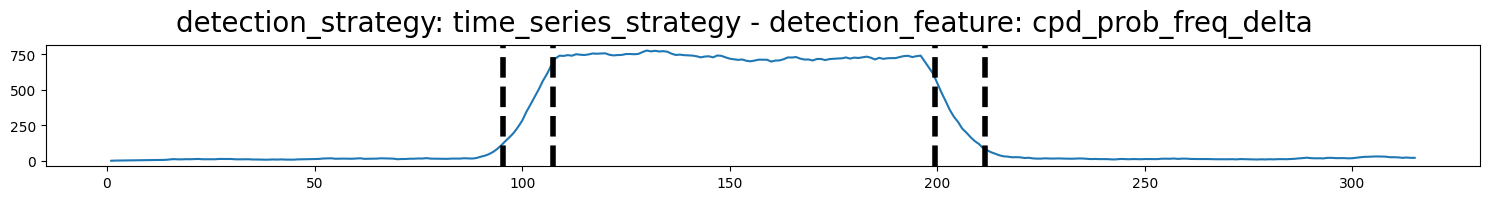

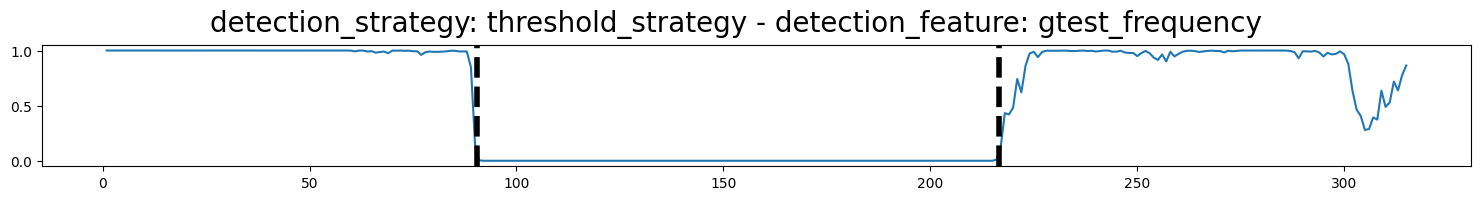

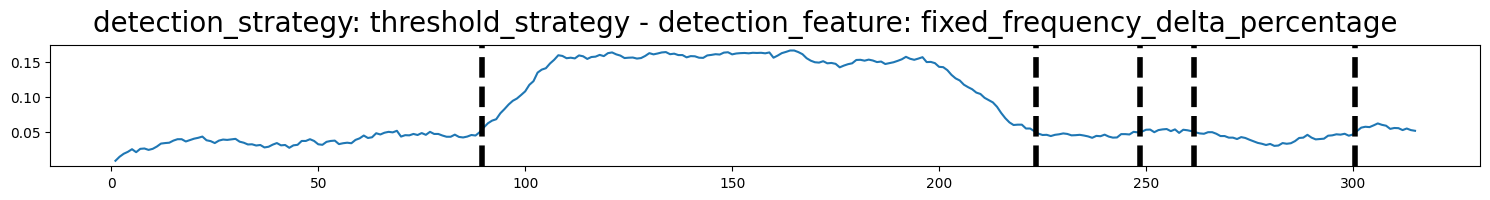

In [12]:
# Display Detection Task Results 
for result in TMPD_instance.get_detection_task().itertuples():
    fig, axarr = rpt.display(signal = TMPD_instance.get_change_representation()[TMPD_instance.detection_task_strategy_dict[result.detection_strategy][result.detection_feature]['change_features']]
                , true_chg_pts=[]
                , computed_chg_pts = result.detection_results
                , computed_chg_pts_color = "k"
                , computed_chg_pts_linewidth = 4
                , computed_chg_pts_linestyle = "--"
                , computed_chg_pts_alpha = 1
                , figsize=(15, 2)
                )
    plt.suptitle("detection_strategy: " + result.detection_strategy + " - detection_feature: " + result.detection_feature , fontsize=20)
    plt.subplots_adjust(top=0.8)
    plt.show()

## Step 6a - Setting Localization Task

In [ ]:
# TODO

## Step 6b - Setting Characterization Task

In [ ]:
# TODO

## Step 6c - Setting Explanation Task

In [ ]:
# TODO